## Fitting Prompt and Non-Prompt photon $p_T$ distributions

### The Fits are used to flatten the $p_T$ distributions such that they are not trained in the neural net

**Dataset 'X' Holds Cluster Varlibales. Each cluster has 29 variables from ROOT NTuple.**
- 0-24 = Cell Fractional Energy (5x5 Cells). 0 if null.
- 25 = Inv.Sqrt(Cluster_E)
- 26 = Cluster Eta (Pseudo Rapidity)
- 27 = min_sm_dazimuth (Line 204 Conver_Sample.cc)
- 28 = v0 multiplicity (saved per cluster?)

**Dataset 'y' holds prompt/non-prompt integer. 1 = prompt; 0 = non-prompt**

In [1]:
from scipy.optimize import curve_fit
import scipy
import scipy.interpolate
import math
import matplotlib.pyplot as plt
import numpy as np
import h5py
import spline_reweights

In [16]:
def bar_errors(data,n_bins,label=''):
    y,binEdges = np.histogram(data,n_bins)
    x = 0.5*(binEdges[1:]+binEdges[:-1]) #bin centers
    width = x[1]-x[0]
    return plt.bar(x, y, width=width, yerr=np.sqrt(y),label=label)

def plot_spline(spline,n_samples,xrange,label=''):
    xnew = np.linspace(xrange[0], xrange[1], num=n_samples, endpoint=True)
    ynew = scipy.interpolate.splev(xnew, spline, der=0)
    return plt.plot(xnew,ynew,"r--",label=label,alpha=0.5,markersize = 4,linewidth=4) 

In [3]:
f = h5py.File('embed_20g3d_pthat4_15o_246392.hdf5', 'r')
cluster_vars = f['X'] 
prompt_bools = f['y']

#combine into single dataset: Element 29 = prompt bool
cluster_dset = np.hstack([cluster_vars,prompt_bools])

**Create Prompt and Non-Prompt Datasets using "Masking"**

In [4]:
prompt = cluster_dset[cluster_dset[:,29] == 1] #Select Prompt Clusters
non_prompt = cluster_dset[cluster_dset[:,29] == 0] #Selects Non-Prompt Clusters

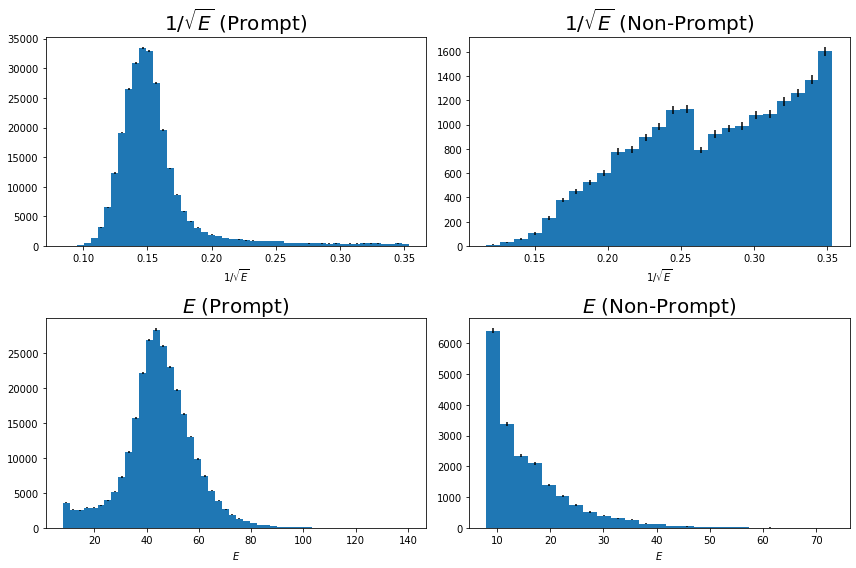

In [8]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2,2,1)
plt.title(r"$1/\sqrt{E}$ (Prompt)",fontsize=20)
prompt_invE = bar_errors(prompt[:,25],50)
plt.xlabel("$1/\sqrt{E}$")

ax = fig.add_subplot(2,2,2)
plt.title(r"$1/\sqrt{E}$ (Non-Prompt)",fontsize=20)
nonprompt_invE = bar_errors(non_prompt[:,25],25)
plt.xlabel("$1/\sqrt{E}$")

ax = fig.add_subplot(2,2,3)
plt.title(r"$E$ (Prompt)",fontsize=20)
prompt_E = bar_errors(prompt[:,25]**-2,50)
plt.xlabel("$E$")

ax = fig.add_subplot(2,2,4)
nonprompt_E = bar_errors(non_prompt[:,25]**-2,25)
plt.title(r"$E$ (Non-Prompt)",fontsize=20)
plt.xlabel("$E$")
plt.tight_layout()

AttributeError: 'list' object has no attribute 'size'

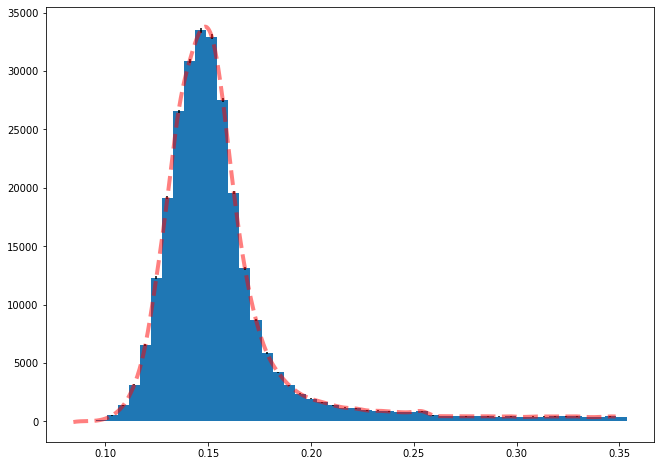

In [25]:
fig = plt.figure(figsize=(24,8))

ax = fig.add_subplot(1,2,1) #prompt

prompt_histo = bar_errors(prompt[:,25],50,'data')
xrange = (prompt_histo[0].get_x(),prompt_histo[-1].get_x())
prompt_spline = spline_reweights.get_spline(prompt[:,25])
p = plot_spline(prompt_spline,1000,xrange,'Spline')
print(len(p)
plt.title(r"$1/\sqrt{E}$ (Prompt)",fontsize=20)
plt.xlabel("$1/\sqrt{E}$")
plt.legend(fontsize=20)


ax = fig.add_subplot(1,2,2) #non-prompt

nonprompt_histo = bar_errors(non_prompt[:,25],50,'data')
nonprompt_spline = spline_reweights.get_spline(non_prompt[:,25])
xrange = (nonprompt_histo[0].get_x(),nonprompt_histo[-1].get_x())
plot_spline(nonprompt_spline,1000,xrange,'Spline')
plt.title(r"$1/\sqrt{E}$ (Non-Prompt)",fontsize=20)
plt.xlabel("$1/\sqrt{E}$")
plt.legend(fontsize=20)

In [ ]:
y = prompt_bools
norm = len(y[ y[:] == 1 ]) / len(y[ y[:] == 0 ]) #N_Prompt/N_non-prompt
test = spline_reweights.reweight_nonprompt(non_prompt[:,25],norm)
print(test)
test = spline_reweights.reweight_prompt(prompt[:,25],norm)
print(test)

In [ ]:
plt.hist(test,100)